In [93]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
from pylab import rcParams
import healpy as hp
from tqdm import *
from astropy import units as u
from scipy.ndimage.filters import gaussian_filter

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from scipy.stats import chi2
from scipy.stats import norm

In [95]:
from plot_params import params
import matplotlib.pylab as pylab

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

alpha_plot = 1.
lw_plot = 2.5

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/smsha

In [3]:
# pylab.rcParams.update(params)
# plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
# plots_dir = "/Users/smsharma/Desktop/LensPower_Offline/plots/"

# data_dir = "/Users/smsharma/QuasarSims/"

In [141]:
## Function to get 95% containment limit

# Calculate exact TS threshold
delta_chi2_thresh = chi2.isf(1 - .68, 1)

from scipy.optimize import brentq
from scipy.interpolate import interp1d

def get_lim(delta_chi2_ary, eps_ary):
    """ Get one-sided 95% containment limits. `delta_chi2_ary` must have shape (len(m_Ap_ary), len(self.eps_ary)).
        Returns limit array of length len(m_Ap_ary), over each mass index.
    """

    TS_m_xsec = np.zeros(3)

    TS_m_xsec[2] = eps_ary[0]

    lim_ary = np.zeros(len(delta_chi2_ary))

    for i_m in range(len(delta_chi2_ary)):

        TS_eps_ary = np.nan_to_num(delta_chi2_ary[i_m], nan=1e10)

        # Find value, location and xsec at the max TS (as a function of mass)
        max_loc = np.argmin(TS_eps_ary)
        max_TS = TS_eps_ary[max_loc]

        if max_TS > TS_m_xsec[0]:
            TS_m_xsec[0] = max_TS
            TS_m_xsec[1] = i_m
            TS_m_xsec[2] = eps_ary[max_loc]
        
        upper_crossing = []
        # Calculate limit
        for xi in range(max_loc, len(eps_ary)):
            val = TS_eps_ary[xi]
            if val > delta_chi2_thresh:
                interp = interp1d(np.log10([eps_ary[xi-1], eps_ary[xi]]),[TS_eps_ary[xi-1], TS_eps_ary[xi]])
                upper_crossing = 10 ** brentq(lambda eps: interp(eps) - delta_chi2_thresh, np.log10(eps_ary[xi-1]), np.log10(eps_ary[xi]))
                break
                
        # Calculate limit
        for xi in range(0, max_loc):
            val = TS_eps_ary[xi]
            if val < delta_chi2_thresh:
                interp = interp1d(np.log10([eps_ary[xi - 1], eps_ary[xi]]),[TS_eps_ary[xi - 1], TS_eps_ary[xi]])
                lower_crossing = 10 ** brentq(lambda eps: interp(eps) - delta_chi2_thresh, np.log10(eps_ary[xi - 1]), np.log10(eps_ary[xi]))
                break

    return upper_crossing - lower_crossing    
    


In [11]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=200., alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

sim.analysis_pipeline(get_sample=True)

Simulating 1588 subhalos between 7.0 and 10.0


/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  This is separate from the ipykernel package so we can avoid doing imports until


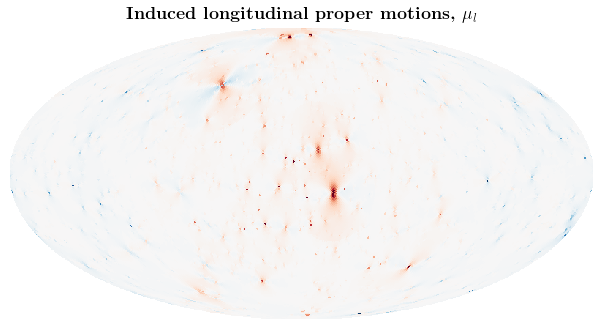

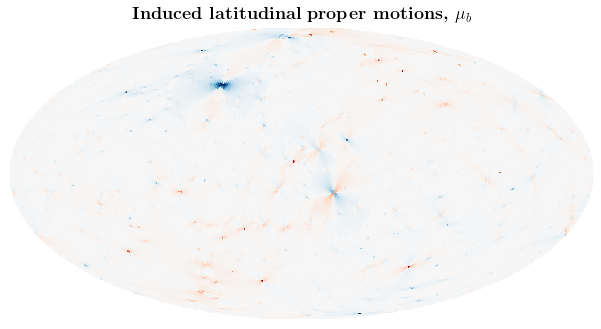

In [12]:
max_mu = 8e-4 / 0.6e-4
cmap = cmaps.RdBu_r
cmap.set_under('w')

hp.mollview(1e6 * sim.mu_qsrs[:,0] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced longitudinal proper motions}, $\mu_l$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)
hp.mollview(1e6 * sim.mu_qsrs[:,1] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced latitudinal proper motions}, $\mu_b$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)

In [13]:
import sys
sys.path.append("../")

from models.embedding import SphericalGraphCNN

In [14]:
nside_list = [64, 32, 16, 8, 4, 2, 1]

In [15]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, mask_ring = False)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])


In [16]:
import torch
in_map = torch.Tensor((sim.mu_qsrs.reshape((1, -1, 2))))
in_map.shape

torch.Size([1, 49152, 2])

In [17]:
log_mean = torch.log(torch.mean(in_map, axis=1))
log_std = torch.log(torch.var(in_map, axis=1).sqrt())

log_mean = log_mean.reshape((1, -1, 2))
log_std = log_std.reshape((1, -1, 2))

data_map = torch.cat([in_map], axis=1)
data_map.shape

torch.Size([1, 49152, 2])

In [18]:
data_map = data_map.view(-1, 2, 49152)

In [19]:
sg = SphericalGraphCNN(nside_list, indexes_list, in_ch=2)

In [20]:
data_map = torch.cat(4 * [data_map])

In [21]:
data_map.shape

torch.Size([4, 2, 49152])

In [22]:
theta = torch.ones([4, 1000])

In [23]:
sg(data_map, theta).shape

torch.Size([4, 64])


## Analysis

In [74]:
import sys
sys.path.append("../")
from sbi.neural_nets.flow import build_maf

from sbi.neural_nets.classifier import build_mlp_mixed_classifier
from sbi import utils
import torch

In [75]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '1936d60ac8f945b4b6873c96a4946f32'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

In [76]:
from tqdm.notebook import tqdm

In [81]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

In [82]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [83]:
n_trials = 50
n_test = 30

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
    sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
    sim.set_subhalo_properties(sim.c200_SCP, distdep=False)
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = torch.Tensor(sim.mu_qsrs)
    
    gn = GaussianNoise(sigma=0.0023)
    x_test = gn(x_test).T
    
#     x_test = torch.Tensor(1 * [x_test.T]).contiguous() 

    theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

    out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test
                                         [i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]

  0%|          | 0/50 [00:00<?, ?it/s]

Simulating 1150 subhalos between 7.0 and 10.0


Simulating 1150 subhalos between 7.0 and 10.0
Simulating 1197 subhalos between 7.0 and 10.0
Simulating 1239 subhalos between 7.0 and 10.0
Simulating 1264 subhalos between 7.0 and 10.0
Simulating 1236 subhalos between 7.0 and 10.0
Simulating 1199 subhalos between 7.0 and 10.0
Simulating 1201 subhalos between 7.0 and 10.0
Simulating 1227 subhalos between 7.0 and 10.0
Simulating 1267 subhalos between 7.0 and 10.0
Simulating 1109 subhalos between 7.0 and 10.0
Simulating 1181 subhalos between 7.0 and 10.0
Simulating 1245 subhalos between 7.0 and 10.0
Simulating 1194 subhalos between 7.0 and 10.0
Simulating 1222 subhalos between 7.0 and 10.0
Simulating 1168 subhalos between 7.0 and 10.0
Simulating 1204 subhalos between 7.0 and 10.0
Simulating 1221 subhalos between 7.0 and 10.0
Simulating 1231 subhalos between 7.0 and 10.0
Simulating 1240 subhalos between 7.0 and 10.0
Simulating 1265 subhalos between 7.0 and 10.0
Simulating 1200 subhalos between 7.0 and 10.0
Simulating 1184 subhalos between 7

In [84]:
out_mean = np.mean(out, axis=0)

In [85]:
llrmin, llrmax = 0., 15.

for out_inst in out:
    llr = - 2 * out_inst
    llr -= np.min(llr)
    llr = np.clip(llr, llrmin, llrmax)
    
    try:
        print(get_lim(np.expand_dims(llr[1:], 0), theta_test.squeeze().detach().numpy()[1:]))
    except:
        continue

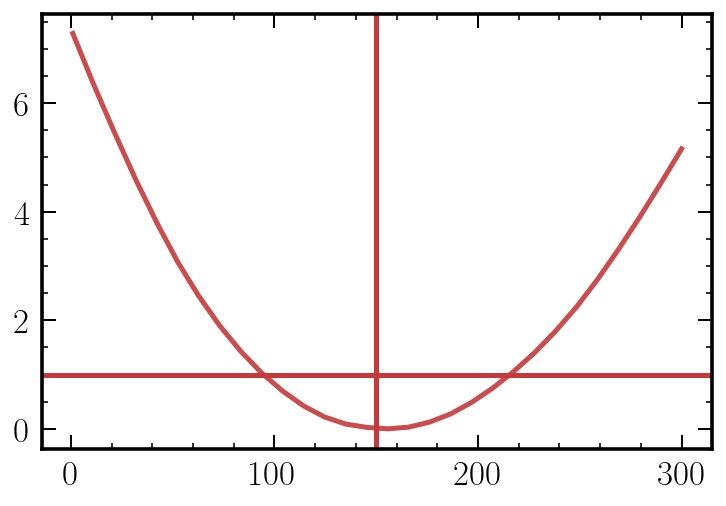

In [86]:
llrmin, llrmax = 0., 15.

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

plt.plot(theta_test.squeeze().detach().numpy(), llr)

plt.axhline(chi2.isf(1 - .68, 1))
plt.axvline(150)

In [87]:
from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

In [88]:
# Precompute some number for NFW and Burkert
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

In [89]:
# Calculate spectra for fiducial CDM

pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_ein_EAQ, R_min=1e-3*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e7*M_s, M_max=1e10*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1.1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_SCP)

C_l_mu = pspecpop.get_C_l_total_ary();

  0%|          | 0/50 [00:00<?, ?it/s]

0.1280184991297499
0.2153241974261756


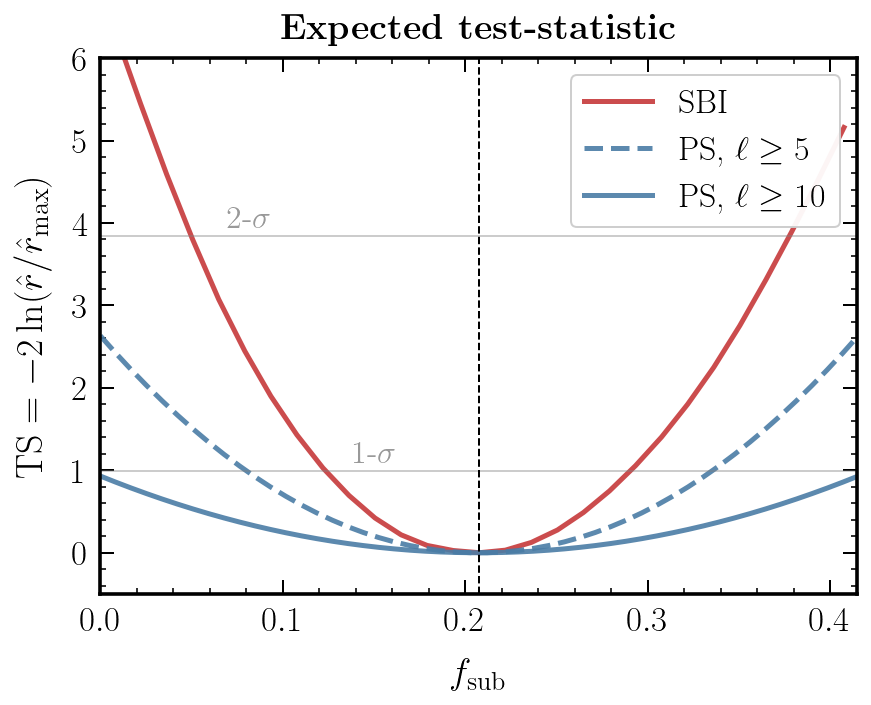

In [201]:
# Test

sigma_mu = .1
sigma_alpha = None
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = pspecpop.C_l_ary*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

M_calib_ary = np.logspace(8, 10) * M_s
calib = 150 / np.trapz(pspecpop.rho_M_SI(M_calib_ary, alpha=-1.9), M_calib_ary)

M_ary = np.logspace(-6, 10) * M_s
f_sub_fid = np.trapz(M_ary * calib * pspecpop.rho_M_SI(M_ary, alpha=-1.9), M_ary) / M_MW

signal = np.linspace(1e-3, 2, 100)

ls_list = ['--', '-']


llrmin, llrmax = 0., 15.

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

offset = (f_sub_fid - (f_sub_fid / 150) * theta_test.squeeze().detach().numpy()[np.argmin(llr[1:]) + 1])
plt.plot(offset + (f_sub_fid / 150) * theta_test.squeeze().detach().numpy(), llr, label="SBI", color=cols_default[0])

for i_l, l_min in enumerate([5, 10]):

    parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=l_min, l_max_mu=300, l_min_alpha=200, l_max_alpha=2000)

    fshr = FisherForecast(parameters, observation)

    sigma=fshr.pars_vary[0].sigma

    x_arr=np.linspace(0, 2)
    LL_ary = norm.logpdf(x_arr, fDM_base, sigma)
    plt.plot(f_sub_fid * x_arr, -2 * (LL_ary - np.max(LL_ary)), label=r"PS, $\ell \geq {}$".format(l_min), ls=ls_list[i_l], color=cols_default[1])
    
    print(fshr.pars_vary[0].sigma * f_sub_fid)

plt.axhline(chi2.isf(1 - .95, 1), color='grey', alpha=0.4, lw=1)
plt.text(f_sub_fid / 3, chi2.isf(1 - .95, 1) + 0.1, r"2-$\sigma$",  color='grey', alpha=0.8, fontsize=16)

plt.axhline(chi2.isf(1 - .68, 1), color='grey', alpha=0.4, lw=1)
plt.text(f_sub_fid / (3 / 2), chi2.isf(1 - .68, 1) + 0.1, r"1-$\sigma$",  color='grey', alpha=0.8, fontsize=16)

plt.axvline(f_sub_fid, color='k', lw=1, ls='--')

plt.ylim(-0.5, 6)
plt.xlim(0.0, 0.415)

plt.legend(loc='upper right', frameon=True, framealpha=0.95)

plt.xlabel(r"$f_\mathrm{sub}$")
plt.ylabel(r"$\mathrm{TS}  = -2 \ln  (\hat r / \hat r_\mathrm{max}) $")

plt.title(r"\bf{Expected test-statistic}", y=1.008)

plt.tight_layout()
# plt.savefig("../paper/ml4ps/figures/TS.pdf")

In [109]:
import healpy as hp
Sigma_q = 1e8 / (4 * np.pi)
pixarea = hp.nside2pixarea(nside=64, degrees=False)
N_q_pix = Sigma_q * pixarea
sigma_pix = .0721 / np.sqrt(N_q_pix)
sigma_pix

# the_map = np.load("../../sbi-astrometry/data/x_train_49.npy")[4, 0] 
# the_map += np.random.normal(loc=0, scale=sigma_pix, size=the_map.shape)
# hp.mollview(the_map, nest=True, cmap='RdBu_r')

0.0015984750492891654

In [110]:
np.linspace(0.0002, 0.005, 10)

array([0.0002    , 0.00073333, 0.00126667, 0.0018    , 0.00233333,
       0.00286667, 0.0034    , 0.00393333, 0.00446667, 0.005     ])

In [111]:
import torch.nn as nn

In [127]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
    """
    def __init__(self, sigma=0.):
        super().__init__()
        self.sigma = sigma
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.sigma != 0.:
            sampled_noise = self.noise.expand(*x.size()).detach().float().normal_() * self.sigma
            x = x + sampled_noise
        return x 

In [128]:
gn = GaussianNoise(sigma=0.0022)
x = torch.zeros((1000000))
gn(x)

tensor([ 0.0011, -0.0010, -0.0007,  ...,  0.0006,  0.0003,  0.0010])

In [129]:
np.random.normal(loc=0, scale=0.0022 / 1., size=(1000000))

array([ 5.05838103e-04,  3.63859078e-05,  2.48844594e-03, ...,
       -5.77049399e-04,  2.50027593e-03, -6.40171424e-04])

## Variation over noise

In [198]:
run_id_list = ['303ceae8593c4ab78a573e1a3b1d83b1', '1936d60ac8f945b4b6873c96a4946f32', 'ede8a36abe9d4baf9dd8bbfbf7d0f158']

n_trials = 30
n_test = 30

lims_ary = np.zeros((len(run_id_list), n_trials))

for i_run, run_id in enumerate(run_id_list):

    data_dir = '/scratch/sm8383/sbi-fermi/data/'
    model_uri = "runs:/{}/density_estimator".format(run_id)
    density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

    list(density_estimator.children())[0].add_noise.sigma = 0.


    out = np.zeros((n_trials, n_test))

    for i_trial in tqdm(range(n_trials)):

        sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
        sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
        sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

        sim.analysis_pipeline(get_sample=True)
        sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T

        x_test = torch.Tensor(sim.mu_qsrs)

        gn = GaussianNoise(sigma=0.0023)
        x_test = gn(x_test).T

    #     x_test = torch.Tensor(1 * [x_test.T]).contiguous() 

        theta_test = torch.linspace(1., 300., n_test).unsqueeze(1)

        out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test
                                             [i].unsqueeze(0)).squeeze().detach().numpy() \
               for i in (range(n_test))]

    llrmin, llrmax = 0., 15.

    for i_trial, out_inst in enumerate(out):
        llr = - 2 * out_inst
        llr -= np.min(llr)
        llr = np.clip(llr, llrmin, llrmax)

        try:
            lim_trial = get_lim(np.expand_dims(llr[:], 0), theta_test.squeeze().detach().numpy()[:])
        except:
            lim_trial = np.nan
            continue
        
        lims_ary[i_run, i_trial] = lim_trial

  0%|          | 0/30 [00:00<?, ?it/s]

Simulating 1229 subhalos between 7.0 and 10.0


  3%|▎         | 1/30 [00:26<13:02, 26.98s/it]

Simulating 1164 subhalos between 7.0 and 10.0


  7%|▋         | 2/30 [00:49<11:24, 24.45s/it]

Simulating 1235 subhalos between 7.0 and 10.0


 10%|█         | 3/30 [01:07<09:39, 21.47s/it]

Simulating 1237 subhalos between 7.0 and 10.0


 13%|█▎        | 4/30 [01:24<08:30, 19.63s/it]

Simulating 1180 subhalos between 7.0 and 10.0


 17%|█▋        | 5/30 [01:40<07:41, 18.45s/it]

Simulating 1242 subhalos between 7.0 and 10.0


 20%|██        | 6/30 [01:57<07:11, 17.99s/it]

Simulating 1222 subhalos between 7.0 and 10.0


 23%|██▎       | 7/30 [02:14<06:46, 17.67s/it]

Simulating 1171 subhalos between 7.0 and 10.0


 27%|██▋       | 8/30 [02:31<06:19, 17.24s/it]

Simulating 1205 subhalos between 7.0 and 10.0


 30%|███       | 9/30 [02:47<05:57, 17.04s/it]

Simulating 1120 subhalos between 7.0 and 10.0


 33%|███▎      | 10/30 [03:03<05:30, 16.51s/it]

Simulating 1232 subhalos between 7.0 and 10.0


 37%|███▋      | 11/30 [03:20<05:18, 16.77s/it]

Simulating 1221 subhalos between 7.0 and 10.0


 40%|████      | 12/30 [03:37<05:01, 16.77s/it]

Simulating 1262 subhalos between 7.0 and 10.0


 43%|████▎     | 13/30 [03:57<05:00, 17.69s/it]

Simulating 1220 subhalos between 7.0 and 10.0


 47%|████▋     | 14/30 [04:15<04:45, 17.81s/it]

Simulating 1194 subhalos between 7.0 and 10.0


 50%|█████     | 15/30 [04:34<04:32, 18.15s/it]

Simulating 1210 subhalos between 7.0 and 10.0


 53%|█████▎    | 16/30 [04:51<04:12, 18.04s/it]

Simulating 1201 subhalos between 7.0 and 10.0


 57%|█████▋    | 17/30 [05:07<03:46, 17.45s/it]

Simulating 1240 subhalos between 7.0 and 10.0


 60%|██████    | 18/30 [05:25<03:30, 17.57s/it]

Simulating 1256 subhalos between 7.0 and 10.0


 63%|██████▎   | 19/30 [05:43<03:12, 17.52s/it]

Simulating 1227 subhalos between 7.0 and 10.0


 67%|██████▋   | 20/30 [06:00<02:53, 17.34s/it]

Simulating 1194 subhalos between 7.0 and 10.0


 70%|███████   | 21/30 [06:16<02:33, 17.05s/it]

Simulating 1185 subhalos between 7.0 and 10.0


 73%|███████▎  | 22/30 [06:32<02:14, 16.85s/it]

Simulating 1207 subhalos between 7.0 and 10.0


 77%|███████▋  | 23/30 [06:52<02:03, 17.66s/it]

Simulating 1266 subhalos between 7.0 and 10.0


 80%|████████  | 24/30 [07:11<01:48, 18.13s/it]

Simulating 1245 subhalos between 7.0 and 10.0


 83%|████████▎ | 25/30 [07:29<01:29, 17.93s/it]

Simulating 1199 subhalos between 7.0 and 10.0


 87%|████████▋ | 26/30 [07:49<01:14, 18.61s/it]

Simulating 1258 subhalos between 7.0 and 10.0


 90%|█████████ | 27/30 [08:17<01:04, 21.35s/it]

Simulating 1227 subhalos between 7.0 and 10.0


 93%|█████████▎| 28/30 [08:36<00:41, 20.71s/it]

Simulating 1204 subhalos between 7.0 and 10.0


 97%|█████████▋| 29/30 [08:53<00:19, 19.63s/it]

Simulating 1150 subhalos between 7.0 and 10.0


  0%|          | 0/30 [00:00<?, ?it/s]

Simulating 1255 subhalos between 7.0 and 10.0


  3%|▎         | 1/30 [00:23<11:30, 23.81s/it]

Simulating 1265 subhalos between 7.0 and 10.0


  7%|▋         | 2/30 [00:42<09:36, 20.60s/it]

Simulating 1165 subhalos between 7.0 and 10.0


 10%|█         | 3/30 [00:58<08:23, 18.64s/it]

Simulating 1211 subhalos between 7.0 and 10.0


 13%|█▎        | 4/30 [01:16<08:01, 18.53s/it]

Simulating 1219 subhalos between 7.0 and 10.0


 17%|█▋        | 5/30 [01:35<07:48, 18.75s/it]

Simulating 1191 subhalos between 7.0 and 10.0


 20%|██        | 6/30 [01:53<07:23, 18.50s/it]

Simulating 1236 subhalos between 7.0 and 10.0


 23%|██▎       | 7/30 [02:14<07:20, 19.14s/it]

Simulating 1268 subhalos between 7.0 and 10.0


 27%|██▋       | 8/30 [02:34<07:04, 19.28s/it]

Simulating 1251 subhalos between 7.0 and 10.0


 30%|███       | 9/30 [02:52<06:38, 18.99s/it]

Simulating 1194 subhalos between 7.0 and 10.0


 33%|███▎      | 10/30 [03:08<06:01, 18.05s/it]

Simulating 1227 subhalos between 7.0 and 10.0


 37%|███▋      | 11/30 [03:26<05:43, 18.09s/it]

Simulating 1205 subhalos between 7.0 and 10.0


 40%|████      | 12/30 [03:45<05:28, 18.27s/it]

Simulating 1222 subhalos between 7.0 and 10.0


 43%|████▎     | 13/30 [04:03<05:10, 18.28s/it]

Simulating 1228 subhalos between 7.0 and 10.0


 47%|████▋     | 14/30 [04:22<04:57, 18.60s/it]

Simulating 1197 subhalos between 7.0 and 10.0


 50%|█████     | 15/30 [04:40<04:32, 18.19s/it]

Simulating 1220 subhalos between 7.0 and 10.0


 53%|█████▎    | 16/30 [04:57<04:12, 18.06s/it]

Simulating 1169 subhalos between 7.0 and 10.0


 57%|█████▋    | 17/30 [05:15<03:52, 17.89s/it]

Simulating 1156 subhalos between 7.0 and 10.0


 60%|██████    | 18/30 [05:32<03:32, 17.68s/it]

Simulating 1217 subhalos between 7.0 and 10.0


 63%|██████▎   | 19/30 [05:51<03:18, 18.01s/it]

Simulating 1177 subhalos between 7.0 and 10.0


 67%|██████▋   | 20/30 [06:08<02:56, 17.63s/it]

Simulating 1192 subhalos between 7.0 and 10.0


 70%|███████   | 21/30 [06:24<02:36, 17.38s/it]

Simulating 1208 subhalos between 7.0 and 10.0


 73%|███████▎  | 22/30 [06:41<02:16, 17.11s/it]

Simulating 1204 subhalos between 7.0 and 10.0


 77%|███████▋  | 23/30 [07:04<02:11, 18.83s/it]

Simulating 1193 subhalos between 7.0 and 10.0


 80%|████████  | 24/30 [07:22<01:52, 18.78s/it]

Simulating 1228 subhalos between 7.0 and 10.0


 83%|████████▎ | 25/30 [07:42<01:34, 18.94s/it]

Simulating 1238 subhalos between 7.0 and 10.0


 87%|████████▋ | 26/30 [08:08<01:24, 21.22s/it]

Simulating 1252 subhalos between 7.0 and 10.0


 90%|█████████ | 27/30 [08:26<01:00, 20.09s/it]

Simulating 1197 subhalos between 7.0 and 10.0


 93%|█████████▎| 28/30 [08:43<00:38, 19.17s/it]

Simulating 1204 subhalos between 7.0 and 10.0


 97%|█████████▋| 29/30 [08:59<00:18, 18.44s/it]

Simulating 1307 subhalos between 7.0 and 10.0


  0%|          | 0/30 [00:00<?, ?it/s]

Simulating 1197 subhalos between 7.0 and 10.0


  3%|▎         | 1/30 [00:18<08:45, 18.12s/it]

Simulating 1255 subhalos between 7.0 and 10.0


  7%|▋         | 2/30 [00:39<09:24, 20.17s/it]

Simulating 1246 subhalos between 7.0 and 10.0


 10%|█         | 3/30 [00:58<08:46, 19.52s/it]

Simulating 1191 subhalos between 7.0 and 10.0


 13%|█▎        | 4/30 [01:18<08:37, 19.92s/it]

Simulating 1162 subhalos between 7.0 and 10.0


 17%|█▋        | 5/30 [01:37<08:02, 19.31s/it]

Simulating 1133 subhalos between 7.0 and 10.0


 20%|██        | 6/30 [01:53<07:15, 18.13s/it]

Simulating 1257 subhalos between 7.0 and 10.0


 23%|██▎       | 7/30 [02:13<07:12, 18.82s/it]

Simulating 1223 subhalos between 7.0 and 10.0


 27%|██▋       | 8/30 [02:30<06:43, 18.36s/it]

Simulating 1182 subhalos between 7.0 and 10.0


 30%|███       | 9/30 [02:47<06:16, 17.92s/it]

Simulating 1222 subhalos between 7.0 and 10.0


 33%|███▎      | 10/30 [03:04<05:53, 17.68s/it]

Simulating 1203 subhalos between 7.0 and 10.0


 37%|███▋      | 11/30 [03:21<05:31, 17.45s/it]

Simulating 1176 subhalos between 7.0 and 10.0


 40%|████      | 12/30 [03:38<05:08, 17.16s/it]

Simulating 1212 subhalos between 7.0 and 10.0


 43%|████▎     | 13/30 [03:55<04:53, 17.24s/it]

Simulating 1221 subhalos between 7.0 and 10.0


 47%|████▋     | 14/30 [04:12<04:34, 17.17s/it]

Simulating 1181 subhalos between 7.0 and 10.0


 50%|█████     | 15/30 [04:28<04:13, 16.90s/it]

Simulating 1241 subhalos between 7.0 and 10.0


 53%|█████▎    | 16/30 [04:46<03:58, 17.04s/it]

Simulating 1147 subhalos between 7.0 and 10.0


 57%|█████▋    | 17/30 [05:02<03:39, 16.90s/it]

Simulating 1202 subhalos between 7.0 and 10.0


 60%|██████    | 18/30 [05:20<03:24, 17.06s/it]

Simulating 1212 subhalos between 7.0 and 10.0


 63%|██████▎   | 19/30 [05:37<03:08, 17.12s/it]

Simulating 1201 subhalos between 7.0 and 10.0


 67%|██████▋   | 20/30 [05:53<02:48, 16.89s/it]

Simulating 1184 subhalos between 7.0 and 10.0


 70%|███████   | 21/30 [06:10<02:31, 16.84s/it]

Simulating 1206 subhalos between 7.0 and 10.0


 73%|███████▎  | 22/30 [06:28<02:17, 17.22s/it]

Simulating 1161 subhalos between 7.0 and 10.0


 77%|███████▋  | 23/30 [06:45<01:58, 16.94s/it]

Simulating 1192 subhalos between 7.0 and 10.0


 80%|████████  | 24/30 [07:01<01:41, 16.88s/it]

Simulating 1144 subhalos between 7.0 and 10.0


 83%|████████▎ | 25/30 [07:17<01:23, 16.67s/it]

Simulating 1216 subhalos between 7.0 and 10.0


 87%|████████▋ | 26/30 [07:34<01:06, 16.73s/it]

Simulating 1148 subhalos between 7.0 and 10.0


 90%|█████████ | 27/30 [07:50<00:49, 16.38s/it]

Simulating 1183 subhalos between 7.0 and 10.0


 93%|█████████▎| 28/30 [08:06<00:32, 16.44s/it]

Simulating 1217 subhalos between 7.0 and 10.0


 97%|█████████▋| 29/30 [08:23<00:16, 16.58s/it]

Simulating 1166 subhalos between 7.0 and 10.0


100%|██████████| 30/30 [08:40<00:00, 17.34s/it]


In [199]:
lims_ary[lims_ary == 0.] = np.nan

0.1280184991297499
0.2153241974261756


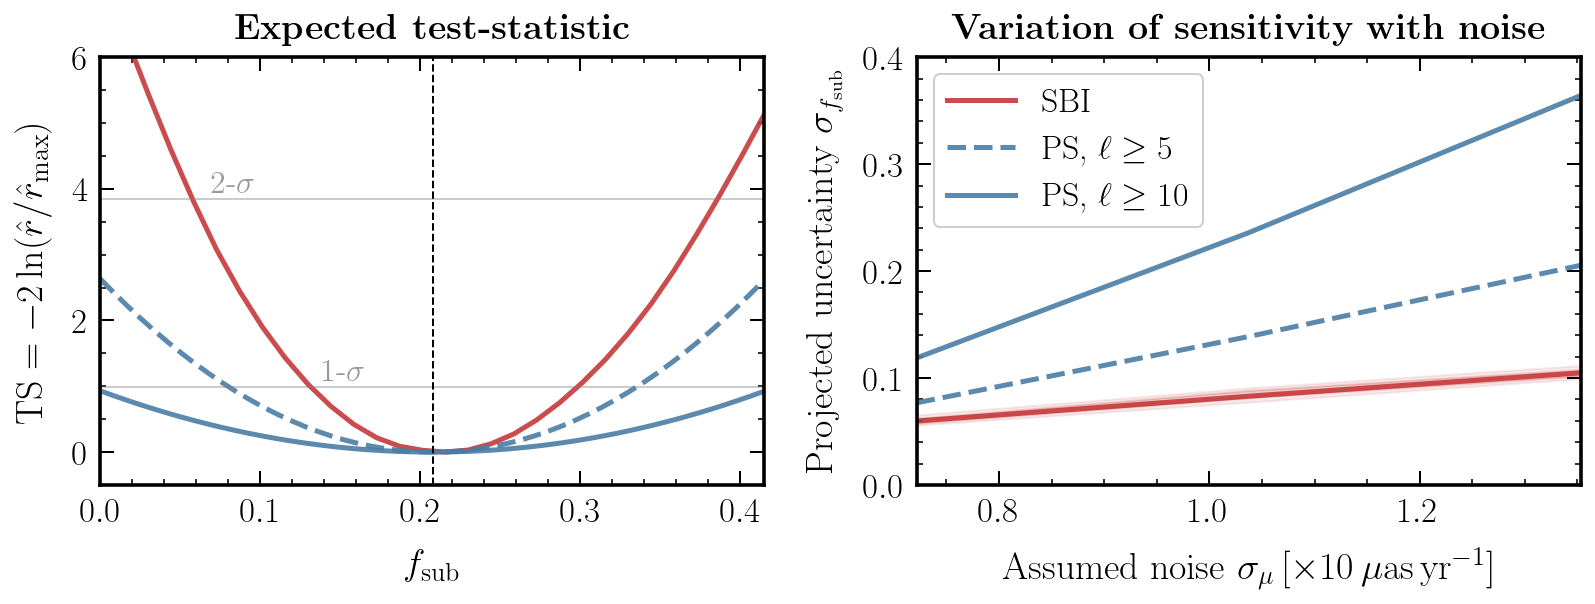

In [205]:
sigma_list = [0.0016, 0.0023, 0.003]

# l_min_list = [2, 5, 10]
l_min_list = [5, 10]

sigma_ps = np.zeros((len(l_min_list), len(sigma_list)))

for i_l, l_min in enumerate(l_min_list):
    for i_s, sigma_mu in enumerate([0.0721, 0.105, 0.132]):    

        N_q = 1e8

        parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
        observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=l_min, l_max_mu=3 * nside - 1, l_min_alpha=200, l_max_alpha=2000)

        fshr = FisherForecast(parameters, observation)

        sigma=fshr.pars_vary[0].sigma
        sigma_ps[i_l, i_s] = (f_sub_fid * sigma)

run_id_list = ['303ceae8593c4ab78a573e1a3b1d83b1', '1936d60ac8f945b4b6873c96a4946f32', 'ede8a36abe9d4baf9dd8bbfbf7d0f158']

perc = (f_sub_fid / 150 / 2) * np.array([np.nanpercentile(lims_ary[i], q=[2.5, 16, 50, 84, 97.5]) for i in range(len(run_id_list))])

fig, ax = plt.subplots(1, 2, figsize=(11.2, 4.3))


ax[1].plot(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), perc[:, 2], label="SBI", color=cols_default[0])
ax[1].fill_between(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), perc[:, 1], perc[:, 3], alpha=0.2, color=cols_default[0])
ax[1].fill_between(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), perc[:, 0], perc[:, 4], alpha=0.1, color=cols_default[0])

for i_s, sigma_mu in enumerate(sigma_ps):
    ax[1].plot(np.array(sigma_list) * 10 * np.sqrt(N_q_pix), sigma_mu, label=r"PS, $\ell \ge {}$".format(l_min_list[i_s]), color=cols_default[1], ls=ls_list[i_s])
    
ax[1].set_xlim(0.0016 * 10 * np.sqrt(N_q_pix), 0.003 * 10 * np.sqrt(N_q_pix))
ax[1].set_ylim(0, 0.4)

ax[1].set_xlabel(r"Assumed noise $\sigma_\mu\,[\times 10\,\mu$as\,yr$^{-1}$]")
ax[1].set_ylabel(r"Projected uncertainty $\sigma_{f_\mathrm{sub}}$")

ax[1].set_title(r"\bf{Variation of sensitivity with noise}", y=1.008)

ax[1].legend(frameon=True, framealpha=0.95)








sigma_mu = .1
sigma_alpha = None
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = pspecpop.C_l_ary*fDM_base

p = pspecpop.C_l_ary*(fDM_base + dfDM_base)
m = pspecpop.C_l_ary*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

M_calib_ary = np.logspace(8, 10) * M_s
calib = 150 / np.trapz(pspecpop.rho_M_SI(M_calib_ary, alpha=-1.9), M_calib_ary)

M_ary = np.logspace(-6, 10) * M_s
f_sub_fid = np.trapz(M_ary * calib * pspecpop.rho_M_SI(M_ary, alpha=-1.9), M_ary) / M_MW

signal = np.linspace(1e-3, 2, 100)

ls_list = ['--', '-']


llrmin, llrmax = 0., 15.

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

offset = 0  #(f_sub_fid - (f_sub_fid / 150) * theta_test.squeeze().detach().numpy()[np.argmin(llr[1:]) + 1])
ax[0].plot(offset + (f_sub_fid / 150) * theta_test.squeeze().detach().numpy(), llr, label="SBI", color=cols_default[0])

for i_l, l_min in enumerate([5, 10]):

    parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=l_min, l_max_mu=300, l_min_alpha=200, l_max_alpha=2000)

    fshr = FisherForecast(parameters, observation)

    sigma=fshr.pars_vary[0].sigma

    x_arr=np.linspace(0, 2)
    LL_ary = norm.logpdf(x_arr, fDM_base, sigma)
    ax[0].plot(f_sub_fid * x_arr, -2 * (LL_ary - np.max(LL_ary)), label=r"PS, $\ell \geq {}$".format(l_min), ls=ls_list[i_l], color=cols_default[1])
    
    print(fshr.pars_vary[0].sigma * f_sub_fid)

ax[0].axhline(chi2.isf(1 - .95, 1), color='grey', alpha=0.4, lw=1)
ax[0].text(f_sub_fid / 3, chi2.isf(1 - .95, 1) + 0.1, r"2-$\sigma$",  color='grey', alpha=0.8, fontsize=16)

ax[0].axhline(chi2.isf(1 - .68, 1), color='grey', alpha=0.4, lw=1)
ax[0].text(f_sub_fid / (3 / 2), chi2.isf(1 - .68, 1) + 0.1, r"1-$\sigma$",  color='grey', alpha=0.8, fontsize=16)

ax[0].axvline(f_sub_fid, color='k', lw=1, ls='--')

ax[0].set_ylim(-0.5, 6)
ax[0].set_xlim(0.0, 0.415)

# ax[0].legend(loc='upper right', frameon=True, framealpha=0.95)

ax[0].set_xlabel(r"$f_\mathrm{sub}$")
ax[0].set_ylabel(r"$\mathrm{TS}  = -2 \ln  (\hat r / \hat r_\mathrm{max}) $")

ax[0].set_title(r"\bf{Expected test-statistic}", y=1.008)

fig.subplots_adjust(wspace=6.)
plt.tight_layout()
plt.savefig("../paper/ml4ps/figures/results.pdf")

## Correlated noise tests

In [35]:
input_map = np.zeros(hp.nside2npix(64))
sigma = 55.
grf = GaussianNoise(sigma=sigma)(torch.Tensor(input_map)).detach().numpy()

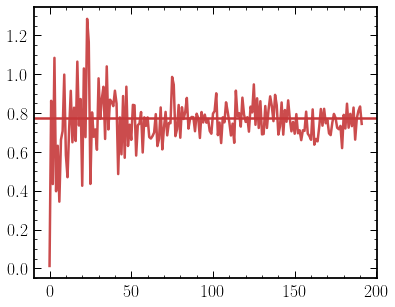

In [36]:
C_l = hp.anafast(grf)
plt.plot(C_l)

plt.axhline(sigma ** 2 * hp.nside2pixarea(64, degrees=False))

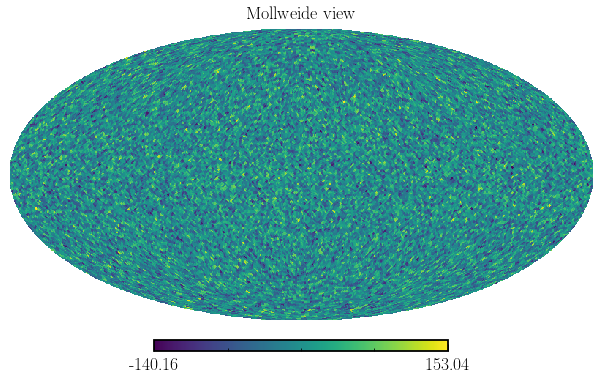

In [37]:
lmax = 64 * 3 - 1

input_cl = sigma ** 2 * hp.nside2pixarea(64, degrees=False) * np.ones(lmax + 1)
input_map = hp.synfast(input_cl, nside=64, pixwin=True)

hp.mollview(input_map)

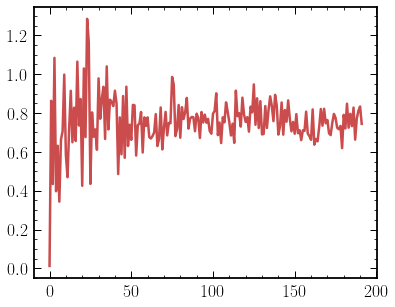

In [38]:
C_l = hp.anafast(grf)
plt.plot(C_l)

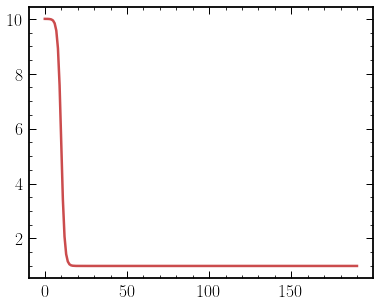

In [39]:
l_ary = np.arange(lmax)

plt.plot(l_ary, 10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.)))

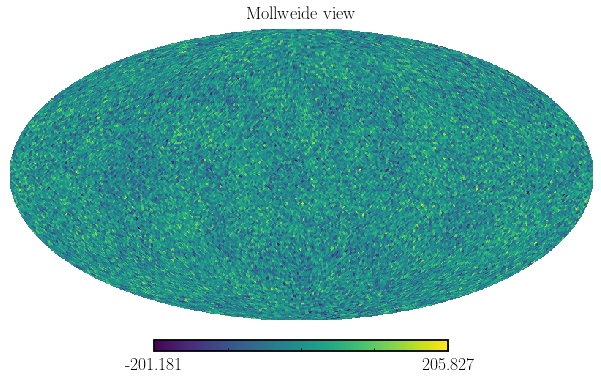

In [40]:
input_cl = sigma ** 2 * hp.nside2pixarea(64, degrees=False) * (10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.)))
synmap = hp.synfast(input_cl, nside=64)
hp.mollview(synmap)

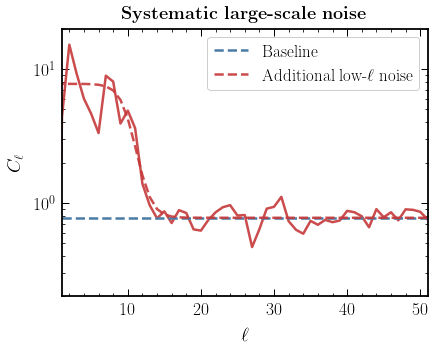

In [52]:
plt.plot(hp.anafast(synmap), color=cols_default[0])
plt.axhline(sigma ** 2 * hp.nside2pixarea(64, degrees=False) , color=cols_default[1], ls='--', label="Baseline")
plt.plot(l_ary, sigma ** 2 * hp.nside2pixarea(64, degrees=False) * (10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.))), color=cols_default[0], ls='--', label="Additional low-$\ell$ noise")

plt.yscale("log")

plt.xlim(1, 51)
plt.ylim(0.2, 20)

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")

plt.title(r"\bf{Systematic large-scale noise}", y=1.008)

plt.legend(frameon=True, framealpha=0.95)

plt.tight_layout()
plt.savefig("../paper/ml4ps/figures/lowell_noise.pdf")

In [53]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '1936d60ac8f945b4b6873c96a4946f32'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-astrometry/data/logs/mlruns/0/' + run_id + '/artifacts/density_estimator')

In [54]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

In [55]:
list(density_estimator.children())[0].add_noise.sigma = 0.

In [56]:
n_trials = 50
n_test = 30

out = np.zeros((n_trials, n_test))

for i_trial in tqdm(range(n_trials)):
    
    sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=150., alpha=-1.9)
    sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
    sim.set_subhalo_properties(sim.c200_SCP, distdep=False)
    
    sim.analysis_pipeline(get_sample=True)
    sim.mu_qsrs = 1e6 * hp.reorder(sim.mu_qsrs.T, r2n=True).T
    
    x_test = torch.Tensor(sim.mu_qsrs)
    
#     gn = GaussianNoise(sigma=0.0023)
#     x_test = gn(x_test).T

    lmax = 64 * 3 - 1
    
    sigma=0.0023
    input_cl = sigma ** 2 * hp.nside2pixarea(64, degrees=False) * (10 - 9 / (1 + np.exp(-(-10 + l_ary) / 1.)))
    noise_test = torch.Tensor([hp.synfast(input_cl, nside=64, pixwin=True), hp.synfast(input_cl, nside=64, pixwin=True)])
    
    x_test = (x_test.T + noise_test)
    
#     x_test = torch.Tensor(1 * [x_test.T]).contiguous() 

    theta_test = torch.linspace(10., 300., n_test).unsqueeze(1)

    out[i_trial, :] = [density_estimator(x_test.unsqueeze(0), theta_test
                                         [i].unsqueeze(0)).squeeze().detach().numpy() \
           for i in (range(n_test))]

  0%|          | 0/50 [00:00<?, ?it/s]

Simulating 1204 subhalos between 7.0 and 10.0


Simulating 1144 subhalos between 7.0 and 10.0
Simulating 1221 subhalos between 7.0 and 10.0
Simulating 1211 subhalos between 7.0 and 10.0
Simulating 1184 subhalos between 7.0 and 10.0
Simulating 1204 subhalos between 7.0 and 10.0
Simulating 1300 subhalos between 7.0 and 10.0
Simulating 1252 subhalos between 7.0 and 10.0
Simulating 1203 subhalos between 7.0 and 10.0
Simulating 1227 subhalos between 7.0 and 10.0
Simulating 1171 subhalos between 7.0 and 10.0
Simulating 1197 subhalos between 7.0 and 10.0
Simulating 1224 subhalos between 7.0 and 10.0
Simulating 1242 subhalos between 7.0 and 10.0
Simulating 1233 subhalos between 7.0 and 10.0
Simulating 1242 subhalos between 7.0 and 10.0
Simulating 1153 subhalos between 7.0 and 10.0
Simulating 1240 subhalos between 7.0 and 10.0
Simulating 1179 subhalos between 7.0 and 10.0
Simulating 1187 subhalos between 7.0 and 10.0
Simulating 1193 subhalos between 7.0 and 10.0
Simulating 1207 subhalos between 7.0 and 10.0
Simulating 1280 subhalos between 7

In [57]:
out_mean_lsnoise = np.mean(out, axis=0)

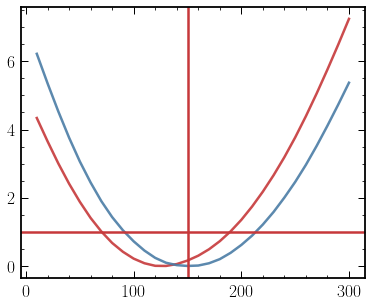

In [68]:
llrmin, llrmax = 0., 15.

llr_lsnoise = - 2 * out_mean_lsnoise
llr_lsnoise -= np.min(llr_lsnoise)
llr_lsnoise = np.clip(llr_lsnoise, llrmin, llrmax)

plt.plot(theta_test.squeeze().detach().numpy(), llr_lsnoise)

llr = - 2 * out_mean
llr -= np.min(llr)
llr = np.clip(llr, llrmin, llrmax)

plt.plot(theta_test.squeeze().detach().numpy(), llr)

plt.axhline(chi2.isf(1 - .68, 1))
plt.axvline(150)

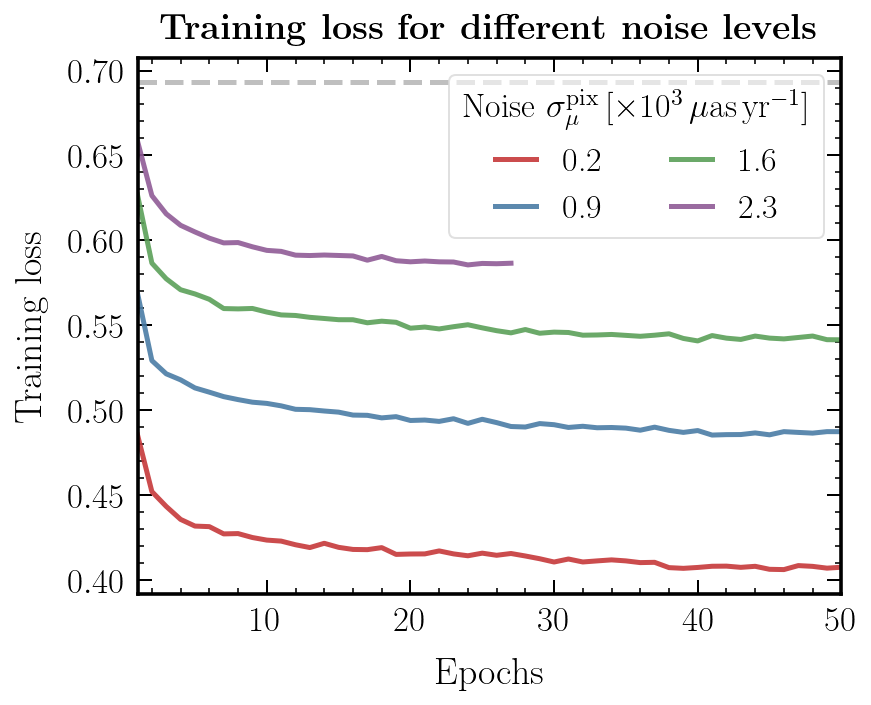

In [1017]:
plt.rcParams['legend.title_fontsize'] = 17

sigma_noise_all = np.linspace(0.0002, 0.003, 5) * 1000

run_id_list = ['c47674d2d8744dfab79d40c06f3b8ac0', 
               '303ceae8593c4ab78a573e1a3b1d83b1', '1936d60ac8f945b4b6873c96a4946f32', 'ede8a36abe9d4baf9dd8bbfbf7d0f158']

for i_r, run_id in enumerate(run_id_list):
    train_loss = np.loadtxt('../data/logs/mlruns/0/{}//metrics/train_loss_epoch'.format(run_id))
    plt.plot(np.arange(1, len(train_loss[:, 1][::2]) + 1), train_loss[:, 1][::2],
                           label=np.round(sigma_noise_all[i_r], 3), color=cols_default[i_r])
#     val_loss = np.loadtxt('../data/logs/mlruns/0/{}//metrics/val_loss'.format(run_id))
#     plt.plot(np.arange(1, len(val_loss[:, 1][::2]) + 1), val_loss[:, 1][::2],
#                            label=np.round(sigma_noise_all[i_r], 3), color=cols_default[i_r], ls='--')

plt.axhline(.693, ls='--', alpha=0.5, color='grey')
plt.xlim(1, 50)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.legend(frameon=True, framealpha=0.6, ncol=2, handlelength=1.2, title=r"Noise $\sigma_\mu^\mathrm{pix}\,[\times 10^3\,\mu$as\,yr$^{-1}$]")

plt.title(r"\bf{Training loss for different noise levels}", y=1.008)

plt.tight_layout()
plt.savefig("../paper/ml4ps/figures/training_loss.pdf")